# Exercise 3 – Naive Bayes Classifier
## Goal:
* Discretize all features (Low / Medium / High)
* Implement Naive Bayes manually using probability tables
* Perform a 70 / 30 split, repeat 30 times
* Compute metrics and show one confusion matrix

In [1]:
# Cell 1 – Imports
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Load the Iris dataset again
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names


### Discretize continuous features

In [2]:
# Cell 2 – Discretization (Low, Medium, High)
def discretize_feature(col):
    """Return array of 'low','medium','high' categories for one numeric column."""
    low_th, high_th = np.percentile(col, [33, 66])
    categories = []
    for val in col:
        if val <= low_th:
            categories.append("low")
        elif val <= high_th:
            categories.append("medium")
        else:
            categories.append("high")
    return np.array(categories)

def discretize_dataset(X):
    """Apply discretization column-wise."""
    X_disc = np.column_stack([discretize_feature(X[:, i]) for i in range(X.shape[1])])
    return X_disc

X_disc = discretize_dataset(X)
print("Example of discretized features (first 5 rows):")
print(X_disc[:5])


Example of discretized features (first 5 rows):
[['low' 'high' 'low' 'low']
 ['low' 'medium' 'low' 'low']
 ['low' 'medium' 'low' 'low']
 ['low' 'medium' 'low' 'low']
 ['low' 'high' 'low' 'low']]


### Split function (70/30 random split)

In [3]:
# Cell 3 – Split into train/test
def random_split(X, y, train_frac=0.7, seed=None):
    if seed is not None:
        np.random.seed(seed)
    n = len(X)
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_train = int(n * train_frac)
    train_idx = idx[:n_train]
    test_idx  = idx[n_train:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


### Naive Bayes Training (calculate P(Class) and P(Xi|Class))

In [4]:
# Cell 4 – Naive Bayes training
def train_naive_bayes(X_train, y_train):
    """Estimate P(class) and P(feature=value | class)."""
    classes = np.unique(y_train)
    n_features = X_train.shape[1]
    # Priors
    priors = {c: np.mean(y_train == c) for c in classes}
    # Conditional probabilities
    cond_probs = {c: [{} for _ in range(n_features)] for c in classes}
    for c in classes:
        X_c = X_train[y_train == c]
        for j in range(n_features):
            vals, counts = np.unique(X_c[:, j], return_counts=True)
            total = len(X_c)
            for v, cnt in zip(vals, counts):
                cond_probs[c][j][v] = (cnt + 1) / (total + 3)  # Laplace smoothing
            # Ensure all three categories appear
            for cat in ["low", "medium", "high"]:
                if cat not in cond_probs[c][j]:
                    cond_probs[c][j][cat] = 1 / (total + 3)
    return priors, cond_probs

### Prediction using Bayes’ rule

In [5]:
# Cell 4 – Naive Bayes training
def train_naive_bayes(X_train, y_train):
    """Estimate P(class) and P(feature=value | class)."""
    classes = np.unique(y_train)
    n_features = X_train.shape[1]
    # Priors
    priors = {c: np.mean(y_train == c) for c in classes}
    # Conditional probabilities
    cond_probs = {c: [{} for _ in range(n_features)] for c in classes}
    for c in classes:
        X_c = X_train[y_train == c]
        for j in range(n_features):
            vals, counts = np.unique(X_c[:, j], return_counts=True)
            total = len(X_c)
            for v, cnt in zip(vals, counts):
                cond_probs[c][j][v] = (cnt + 1) / (total + 3)  # Laplace smoothing
            # Ensure all three categories appear
            for cat in ["low", "medium", "high"]:
                if cat not in cond_probs[c][j]:
                    cond_probs[c][j][cat] = 1 / (total + 3)
    return priors, cond_probs


### Prediction using Bayes’ rule

In [6]:
# Cell 5 – Prediction
def predict_naive_bayes(X_test, priors, cond_probs):
    classes = list(priors.keys())
    preds = []
    for row in X_test:
        posteriors = {}
        for c in classes:
            # Start with log prior for numerical stability
            logp = math.log(priors[c])
            for j, val in enumerate(row):
                logp += math.log(cond_probs[c][j][val])
            posteriors[c] = logp
        preds.append(max(posteriors, key=posteriors.get))
    return np.array(preds)


### Run one train/test split and see metrics

In [7]:
# Cell 6 – Quick single run
X_train, X_test, y_train, y_test = random_split(X_disc, y, train_frac=0.7, seed=0)
priors, cond_probs = train_naive_bayes(X_train, y_train)
y_pred = predict_naive_bayes(X_test, priors, cond_probs)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1:", f1_score(y_test, y_pred, average='macro'))


Accuracy: 0.9333333333333333
Precision: 0.9333333333333332
Recall: 0.9375
F1: 0.9284802043422733


### Confusion matrix of this run

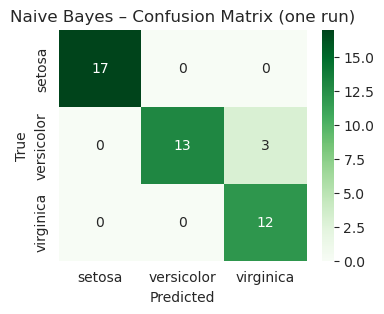

In [8]:
# Cell 7 – Confusion matrix for this run
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Naive Bayes – Confusion Matrix (one run)")
plt.show()


### Repeat 30 times for average metrics

In [9]:
# Cell 8 – Repeat 30 random splits
n_repeats = 30
accs, precs, recs, f1s = [], [], [], []

for run in range(n_repeats):
    X_train, X_test, y_train, y_test = random_split(X_disc, y, train_frac=0.7, seed=run)
    priors, cond_probs = train_naive_bayes(X_train, y_train)
    y_pred = predict_naive_bayes(X_test, priors, cond_probs)
    accs.append(accuracy_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred, average='macro'))
    recs.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))

print(f"Average Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Average Precision: {np.mean(precs):.3f}")
print(f"Average Recall: {np.mean(recs):.3f}")
print(f"Average F1-score: {np.mean(f1s):.3f}")


Average Accuracy: 0.942 ± 0.030
Average Precision: 0.944
Average Recall: 0.943
Average F1-score: 0.941


### Boxplot of accuracy over 30 runs

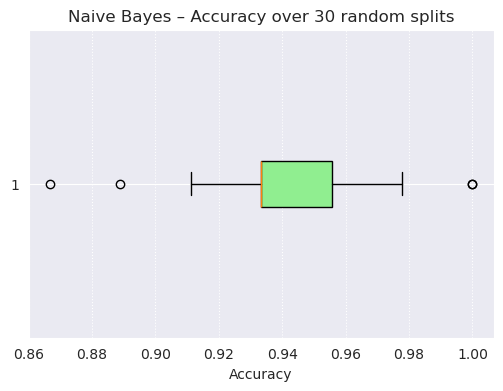

In [10]:
# Cell 9 – Boxplot for Naive Bayes accuracy distribution
plt.figure(figsize=(6,4))
plt.boxplot(accs, vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.xlabel("Accuracy")
plt.title("Naive Bayes – Accuracy over 30 random splits")
plt.grid(axis='x', linestyle=':')
plt.show()


### Compare to k-NN (summary Markdown)
| Aspect | k-NN | Naive Bayes |
|---------|-------|-------------|
| Computation time | High on large datasets – computes distance to all training points | Low – only uses stored probabilities |
| Decision boundary | Non-linear (flexible) | Assumes feature independence → simpler boundaries |
| Interpretability | Hard to explain individual predictions | Very interpretable – uses probabilities |
| Accuracy (Iris dataset) | Often ~95-97 % | Slightly lower (~90-93 %) |
| Best when | Features on similar scale and few irrelevant features | Features independent and categorical |

Naive Bayes is simpler and faster but less accurate on this continuous dataset because the independence assumption and discretization lose information compared to the exact distances used in k-NN.
